In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from matplotlib import pyplot as plt
import os
import random
from tqdm.notebook import tqdm
import pandas as pd

tf.__version__

'2.3.1'

In [2]:
base_dir = './'
train_clean_dir = base_dir + 'train/clean/'
train_noisy_dir = base_dir + 'train/noisy/'
val_clean_dir = base_dir + 'val/clean/'
val_noisy_dir = base_dir + 'val/noisy/'
size = 80  # spectrgram width in pixels

(875, 80)
(875, 80)


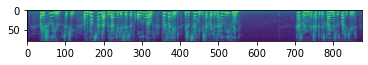

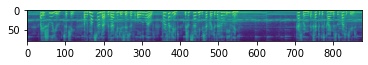

In [3]:
# check data dimensions and examples of clean and noisy spectrograms
clean_spec = np.load('./train/clean/20/20_205_20-205-0004.npy')
noisy_spec = np.load('./train/noisy/20/20_205_20-205-0004.npy')
print(clean_spec.shape)
print(noisy_spec.shape)
plt.imshow(clean_spec.T.astype(float))
plt.figure()
plt.imshow(noisy_spec.T.astype(float))

In [4]:
def load_files_list(directory):
    """ load files list from directory tree """
    files_list = []
    speakers = os.listdir(directory)
    for speaker in speakers:
        if os.path.isdir(directory + speaker):
            files = os.listdir(directory + speaker)
            for f in files:
                if os.path.isfile(directory + speaker + '/' + f):
                    files_list.append(directory + speaker + '/' + f)
    return files_list

In [5]:
def load_file_with_label(fname):
    """ load npy file with spectrogram, cut it on sizeXsize batch and return with label """
    data = np.load(fname).T.astype(float)
    X, y = None, None
    if data.shape[1] >= size:
        X = data[0:size,0:size].reshape((1,size,size,1))
        for i in range(1, data.shape[1] // size):
            cut = data[0:size,i*size:(i+1)*size].reshape((1,size,size,1))
            X = np.concatenate((X, cut), axis=0)
        if 'clean' in fname:
            y = np.array([0 for i in range(X.shape[0])])
        elif 'noisy' in fname:
            y = np.array([1 for i in range(X.shape[0])])
        else:
            print('******** ERROR UNKNOWN LABEL *********')
    return X, y

In [6]:
def load_set(files):
    """ load dataset """
    split = 500
    big_loop = len(files) // split
    set_X, set_y = load_file(files[-1])
    for i in tqdm(range(big_loop)):
        tmp_X, tmp_y = load_file_with_label(files[i*split])
        for j in range(1, split):
            X, y = load_file_with_label(files[i*split+j])
            if X is not None:
                tmp_X = np.concatenate((tmp_X, X), axis=0)
                tmp_y = np.concatenate((tmp_y, y))
        set_X = np.concatenate((set_X, tmp_X), axis=0)
        set_y = np.concatenate((set_y, tmp_y))
        
    return set_X, set_y

In [7]:
train_clean_files = load_files_list(train_clean_dir)
train_noisy_files = load_files_list(train_noisy_dir)
val_clean_files = load_files_list(val_clean_dir)
val_noisy_files = load_files_list(val_noisy_dir)
print(f'found {len(train_clean_files)} clean train files, {len(train_noisy_files)} noisy train files')
print(f'{len(val_clean_files)} test clean files, {len(val_noisy_files)} test noisy files')

found 12000 clean train files, 12000 noisy train files
2000 test clean files, 2000 test noisy files


In [8]:
# make shuffled train files list
train_files = train_clean_files + train_noisy_files
random.shuffle(train_files)
train_files[:10] 

['./train/noisy/6777/6777_76701_6777-76701-0049.npy',
 './train/clean/2062/2062_143900_2062-143900-0075.npy',
 './train/noisy/8172/8172_281511_8172-281511-0020.npy',
 './train/noisy/7749/7749_8591_7749-8591-0041.npy',
 './train/noisy/3109/3109_144137_3109-144137-0057.npy',
 './train/clean/1704/1704_142310_1704-142310-0011.npy',
 './train/noisy/5911/5911_48574_5911-48574-0037.npy',
 './train/clean/4196/4196_23901_4196-23901-0025.npy',
 './train/noisy/6610/6610_34596_6610-34596-0008.npy',
 './train/clean/727/727_124443_727-124443-0069.npy']

In [9]:
train_X, train_y = load_set(train_files)
print(f'train set shape: {train_X.shape}')


train set shape: (216044, 80, 80, 1)


In [10]:
# check train dimensions and ranges
print(train_X.shape, train_y.shape)
print(np.min(train_X), np.max(train_X))
print(np.min(train_y), np.max(train_y))

(216044, 80, 80, 1) (216044,)
-1.7626953125 1.783203125
0 1


In [11]:
# make shuffled test files list
val_files = val_clean_files + val_noisy_files
random.shuffle(val_files)
val_files[:10] 

['./val/clean/453/453_129306_453-129306-0046.npy',
 './val/clean/5765/5765_231844_5765-231844-0016.npy',
 './val/noisy/1154/1154_134886_1154-134886-0000.npy',
 './val/noisy/6590/6590_64283_6590-64283-0021.npy',
 './val/clean/2234/2234_64149_2234-64149-0004.npy',
 './val/clean/6807/6807_106437_6807-106437-0072.npy',
 './val/noisy/6713/6713_56749_6713-56749-0018.npy',
 './val/noisy/149/149_125760_149-125760-0012.npy',
 './val/noisy/6177/6177_75790_6177-75790-0034.npy',
 './val/noisy/782/782_126738_782-126738-0108.npy']

In [12]:
val_X, val_y = load_set(val_files)
print(f'test set shape: {val_X.shape}')


test set shape: (35829, 80, 80, 1)


In [13]:
# check test dimensions and ranges
print(val_X.shape, val_y.shape)
print(np.min(val_X), np.max(val_X))
print(np.min(val_y), np.max(val_y))

(35829, 80, 80, 1) (35829,)
-1.7626953125 1.7216796875
0 1


In [14]:
def make_nn():
    model = tf.keras.Sequential([
        Conv2D(8, (3,3), input_shape=(size,size,1), activation='relu', padding='same'),
        MaxPool2D((2,2)),
        Conv2D(16, (3,3), activation='relu', padding='same'),
        MaxPool2D((2,2)),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        MaxPool2D((2,2)),
        Flatten(),
        Dropout(0.4),
        Dense(16, activation='relu'),
        Dropout(0.4),
        Dense(2, activation='softmax')       
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
model = make_nn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0

In [16]:
early_stopping = EarlyStopping(patience=4, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, verbose=1)
h = model.fit(train_X, train_y, batch_size=64, epochs=30, validation_split=0.1, callbacks=[reduce_lr, early_stopping])

Epoch 1/30
3039/3039 [==============================] - 19s 6ms/step - loss: 0.2076 - accuracy: 0.9302 - val_loss: 0.1200 - val_accuracy: 0.9556
Epoch 2/30
3039/3039 [==============================] - 18s 6ms/step - loss: 0.1390 - accuracy: 0.9558 - val_loss: 0.1184 - val_accuracy: 0.9649
Epoch 3/30
3039/3039 [==============================] - 18s 6ms/step - loss: 0.1208 - accuracy: 0.9627 - val_loss: 0.0877 - val_accuracy: 0.9723
Epoch 4/30
3039/3039 [==============================] - 18s 6ms/step - loss: 0.1089 - accuracy: 0.9671 - val_loss: 0.0927 - val_accuracy: 0.9744
Epoch 5/30
3039/3039 [==============================] - 18s 6ms/step - loss: 0.1025 - accuracy: 0.9690 - val_loss: 0.0846 - val_accuracy: 0.9750
Epoch 6/30
3039/3039 [==============================] - 18s 6ms/step - loss: 0.0989 - accuracy: 0.9703 - val_loss: 0.0831 - val_accuracy: 0.9744
Epoch 7/30
3039/3039 [==============================] - 18s 6ms/step - loss: 0.0946 - accuracy: 0.9718 - val_loss: 0.0790 - val_ac

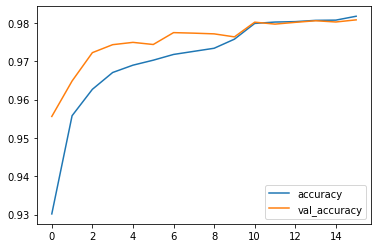

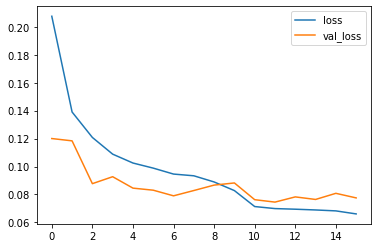

In [17]:
df = pd.DataFrame(h.history)
df.plot(y=['accuracy', 'val_accuracy'])
df.plot(y=['loss', 'val_loss'])

In [19]:
loss, acc = model.evaluate(val_X, val_y)
print(f'test loss = {loss}, test accuracy = {acc}')

1120/1120 [==============================] - 3s 3ms/step - loss: 0.0846 - accuracy: 0.9770
test loss = 0.0845646932721138, test accuracy = 0.9770298004150391


In [20]:
model.save('classify.h5')

In [21]:
# testing random clean and noisy files
check_clean, label_clean = load_file('./train/clean/20/20_205_20-205-0004.npy')
check_noisy, label_noisy = load_file('./train/noisy/20/20_205_20-205-0004.npy')
print(check_clean.shape, label_clean)
print(check_noisy.shape, label_noisy)

(10, 80, 80, 1) [0 0 0 0 0 0 0 0 0 0]
(10, 80, 80, 1) [1 1 1 1 1 1 1 1 1 1]


In [22]:
model.predict(check_clean).mean(axis=0).argmax()

0

In [23]:
model.predict(check_noisy).mean(axis=0).argmax()

1